# Grouped Convex Hull Algorithm with DK Hierarchy

This notebook visualizes a hierarchical grouped convex hull construction algorithm that uses:
- **Hierarchical Grouping**: Multiple levels based on log log(3n-6)
- **Preparata-Hong Algorithm**: For computing convex hulls within groups
- **Dual DK Hierarchy**: For efficient tangent finding
- **Incremental Construction**: Building the final hull face by face

The algorithm divides points into groups, computes local hulls, and merges them using tangent queries.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial import ConvexHull
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Generate random 3D points
np.random.seed(27)
n_points = 100  # Total number of points
points = np.random.randn(n_points, 3)
print(f"Generated {n_points} random 3D points")

Generated 100 random 3D points


## Algorithm Framework

### Main Components:
1. **Hierarchical Grouping**: Divide points into groups at multiple levels
2. **Local Hull Construction**: Use Preparata-Hong for each group
3. **Dual DK Hierarchy**: Build dual structure for tangent queries
4. **Hull Merging**: Incrementally merge local hulls using tangent finding

In [6]:
# ============================================
# Part 1: DK Hierarchy (from previous work)
# ============================================

def get_vertex_degree(hull):
    """Calculate the degree of each vertex in the convex hull"""
    vertex_degree = {}
    for simplex in hull.simplices:
        for vertex in simplex:
            if vertex not in vertex_degree:
                vertex_degree[vertex] = 0
            vertex_degree[vertex] += 1
    return vertex_degree

def find_independent_set(hull, max_degree=8):
    """Find an independent set of low-degree vertices"""
    vertex_degree = get_vertex_degree(hull)
    low_degree_vertices = [v for v, d in vertex_degree.items() if d <= max_degree]
    
    if not low_degree_vertices:
        return []
    
    # Build adjacency
    adjacent = {v: set() for v in range(len(hull.points))}
    for simplex in hull.simplices:
        for i in range(len(simplex)):
            for j in range(i+1, len(simplex)):
                adjacent[simplex[i]].add(simplex[j])
                adjacent[simplex[j]].add(simplex[i])
    
    # Greedy independent set
    independent_set = []
    used = set()
    for vertex in low_degree_vertices:
        if vertex not in used:
            independent_set.append(vertex)
            used.add(vertex)
            used.update(adjacent[vertex])
    
    return independent_set

def build_dk_hierarchy(points):
    """Build Dobkin-Kirkpatrick hierarchy for a point set"""
    hierarchy = []
    current_points = points.copy()
    
    while len(current_points) > 4:
        try:
            hull = ConvexHull(current_points)
        except:
            break
        
        independent_set = find_independent_set(hull)
        if not independent_set:
            break
        
        hierarchy.append({
            'points': current_points.copy(),
            'hull': hull,
            'removed_indices': independent_set
        })
        
        mask = np.ones(len(current_points), dtype=bool)
        mask[independent_set] = False
        current_points = current_points[mask]
        
        if len(current_points) < 4:
            break
    
    if len(current_points) >= 4:
        try:
            hull = ConvexHull(current_points)
            hierarchy.append({
                'points': current_points.copy(),
                'hull': hull,
                'removed_indices': []
            })
        except:
            pass
    
    return hierarchy

print("DK Hierarchy implementation complete")

DK Hierarchy implementation complete


In [7]:
# ============================================
# Part 2: Preparata-Hong Algorithm (Simplified)
# ============================================

def preparata_hong(points):
    """
    Preparata-Hong convex hull algorithm (simplified version)
    For 3D points, we'll use the standard convex hull as a placeholder
    
    Implement the actual Preparata-Hong divide-and-conquer algorithm
    """
    try:
        hull = ConvexHull(points)
        return {
            'points': points,
            'hull': hull,
            'vertices': points[hull.vertices],
            'simplices': hull.simplices
        }
    except:
        return None

print("Preparata-Hong algorithm (simplified) defined")

Preparata-Hong algorithm (simplified) defined


In [8]:
# ============================================
# Part 3: Dual DK Hierarchy
# ============================================

def build_dual_graph(hull):
    """Build dual graph where faces become vertices and adjacent faces are connected."""
    n_faces = len(hull.simplices)

    # Build edge-to-face mapping
    edge_to_faces = {}
    for face_idx, simplex in enumerate(hull.simplices):
        edges = [
            tuple(sorted([simplex[0], simplex[1]])),
            tuple(sorted([simplex[1], simplex[2]])),
            tuple(sorted([simplex[2], simplex[0]]))
        ]
        for edge in edges:
            edge_to_faces.setdefault(edge, []).append(face_idx)

    # Build adjacency list for dual graph
    dual_adjacency = {i: set() for i in range(n_faces)}
    for faces in edge_to_faces.values():
        if len(faces) == 2:
            a, b = faces
            dual_adjacency[a].add(b)
            dual_adjacency[b].add(a)

    return {
        'adjacency': dual_adjacency,
        'edge_to_faces': edge_to_faces,
        'n_faces': n_faces
    }

def build_dual_dk_hierarchy(hull_info):
    """Build the dual DK hierarchy for a convex hull."""
    if hull_info is None:
        return None

    hull = hull_info['hull']
    dual_graph = build_dual_graph(hull)
    dk_hierarchy = build_dk_hierarchy(hull_info['points'])

    return {
        'original_hull': hull,
        'dk_hierarchy': dk_hierarchy,
        'dual_structure': dual_graph
    }

print("Dual DK hierarchy framework defined")

Dual DK hierarchy framework defined


In [9]:
# ============================================
# Part 4: Tangent Finding
# ============================================

def compute_plane_normal(p1, p2):
    """Compute a stable normal vector for the plane defined by an edge and origin."""
    v1 = p2 - p1
    v2 = (p1 + p2) / 2
    normal = np.cross(v1, v2)
    norm = np.linalg.norm(normal)
    if norm > 1e-10:
        return normal / norm
    return normal

def compute_angle(plane_normal, edge_point, candidate_point):
    """Compute angle between plane normal and vector to candidate point."""
    vec_to_candidate = candidate_point - edge_point
    norm = np.linalg.norm(vec_to_candidate)
    if norm < 1e-10:
        return 0.0
    vec_to_candidate = vec_to_candidate / norm
    cos_angle = np.dot(plane_normal, vec_to_candidate)
    return np.arccos(np.clip(cos_angle, -1.0, 1.0))

def tangent_find(edge_points, dual_dk, group_hull_info):
    """Find the tangent point from an edge to a group's hull."""
    if dual_dk is None or dual_dk['original_hull'] is None or group_hull_info is None:
        return None

    hull = dual_dk['original_hull']
    hull_points = group_hull_info['points']
    hull_vertices = hull_points[hull.vertices]

    if len(hull_vertices) == 0:
        return None

    p1, p2 = edge_points
    edge_midpoint = (p1 + p2) / 2
    plane_normal = compute_plane_normal(p1, p2)

    best_point = None
    best_angle = -np.inf

    for vertex in hull_vertices:
        if np.allclose(vertex, p1) or np.allclose(vertex, p2):
            continue
        angle = compute_angle(plane_normal, edge_midpoint, vertex)
        if angle > best_angle:
            best_angle = angle
            best_point = vertex

    return best_point

print("Tangent finding with angle computation defined")

Tangent finding with angle computation defined


In [10]:
# ============================================
# Part 5: Main Algorithm
# ============================================

def grouped_convex_hull_algorithm(points, visualize_steps=True):
    """
    Main algorithm: Hierarchical grouped convex hull construction
    """
    n = len(points)

    # Calculate number of levels
    num_levels = max(1, int(np.ceil(np.log2(np.log2(3 * n - 6)))) if n > 2 else 1)
    print("\nAlgorithm Parameters:")
    print(f"n = {n} points")
    print(f"Number of levels = {num_levels}")

    all_results = []

    for level in range(1, num_levels + 1):
        print(f"\n{'=' * 50}")
        print(f"Level {level}")
        print(f"{'=' * 50}")

        # Calculate group size for this level
        m = 2 ** (2 ** level)
        num_groups = max(1, int(np.ceil(n / m)))

        print(f"Group size m = 2^(2^{level}) = {m}")
        print(f"Number of groups = ⌈{n}/{m}⌉ = {num_groups}")

        # Create groups
        groups = []
        groups_hulls = []
        dual_hierarchies = []

        for j in range(num_groups):
            start_idx = j * m
            end_idx = min((j + 1) * m, n)
            group_points = points[start_idx:end_idx]

            print(f"\n  Group {j}: points [{start_idx}:{end_idx}] ({len(group_points)} points)")

            hull_info = preparata_hong(group_points)
            dual_dk = build_dual_dk_hierarchy(hull_info)

            groups.append(group_points)
            groups_hulls.append(hull_info)
            dual_hierarchies.append(dual_dk)

        # Incremental hull construction using tangent finding
        print("\n  Building merged hull incrementally...")
        merged_hull_faces = []
        wrap_steps = []

        # Start with first face from first group
        if groups_hulls and groups_hulls[0] is not None:
            initial_hull = groups_hulls[0]['hull']
            initial_points = groups_hulls[0]['points']

            if len(initial_hull.simplices) > 0:
                first_simplex = initial_hull.simplices[0]
                first_face = [initial_points[i] for i in first_simplex]
                merged_hull_faces.append(first_face)

                # Add edges to queue
                edge_queue = []
                seen_edges = set()
                for i in range(3):
                    edge = (tuple(first_face[i]), tuple(first_face[(i + 1) % 3]))
                    if edge not in seen_edges:
                        edge_queue.append(edge)
                        seen_edges.add(edge)
                        seen_edges.add((edge[1], edge[0]))

                print(f"    Starting with face, {len(edge_queue)} edges in queue")

                # Process edges (limit iterations for demo)
                max_iterations = min(10, len(initial_hull.simplices))
                for _ in range(max_iterations):
                    if not edge_queue:
                        break

                    edge = edge_queue.pop(0)
                    edge_points = (np.array(edge[0]), np.array(edge[1]))

                    tangent_candidates = []
                    for g_idx in range(num_groups):
                        tangent_pt = tangent_find(
                            edge_points,
                            dual_hierarchies[g_idx],
                            groups_hulls[g_idx]
                        )
                        if tangent_pt is not None:
                            tangent_candidates.append(tangent_pt)

                    if tangent_candidates:
                        best_tangent = tangent_candidates[0]
                        new_face = [edge_points[0], edge_points[1], best_tangent]
                        merged_hull_faces.append(new_face)
                        wrap_steps.append({
                            'edge': edge_points,
                            'point': best_tangent,
                            'face': new_face
                        })

                        for i in range(3):
                            new_edge = (tuple(new_face[i]), tuple(new_face[(i + 1) % 3]))
                            if new_edge not in seen_edges and len(edge_queue) < 20:
                                edge_queue.append(new_edge)
                                seen_edges.add(new_edge)
                                seen_edges.add((new_edge[1], new_edge[0]))

                print(f"    Incremental construction: {len(merged_hull_faces)} faces built")

        level_result = {
            'level': level,
            'm': m,
            'groups': groups,
            'groups_hulls': groups_hulls,
            'dual_hierarchies': dual_hierarchies,
            'merged_hull_faces': merged_hull_faces,
            'wrap_steps': wrap_steps
        }
        all_results.append(level_result)

    return all_results

# Run the algorithm
results = grouped_convex_hull_algorithm(points)
print("\n" + "=" * 50)
print("Algorithm execution complete")
print("=" * 50)


Algorithm Parameters:
n = 100 points
Number of levels = 4

Level 1
Group size m = 2^(2^1) = 4
Number of groups = ⌈100/4⌉ = 25

  Group 0: points [0:4] (4 points)

  Group 1: points [4:8] (4 points)

  Group 2: points [8:12] (4 points)

  Group 3: points [12:16] (4 points)

  Group 4: points [16:20] (4 points)

  Group 5: points [20:24] (4 points)

  Group 6: points [24:28] (4 points)

  Group 7: points [28:32] (4 points)

  Group 8: points [32:36] (4 points)

  Group 9: points [36:40] (4 points)

  Group 10: points [40:44] (4 points)

  Group 11: points [44:48] (4 points)

  Group 12: points [48:52] (4 points)

  Group 13: points [52:56] (4 points)

  Group 14: points [56:60] (4 points)

  Group 15: points [60:64] (4 points)

  Group 16: points [64:68] (4 points)

  Group 17: points [68:72] (4 points)

  Group 18: points [72:76] (4 points)

  Group 19: points [76:80] (4 points)

  Group 20: points [80:84] (4 points)

  Group 21: points [84:88] (4 points)

  Group 22: points [88:92] (4


Visualizing all levels...


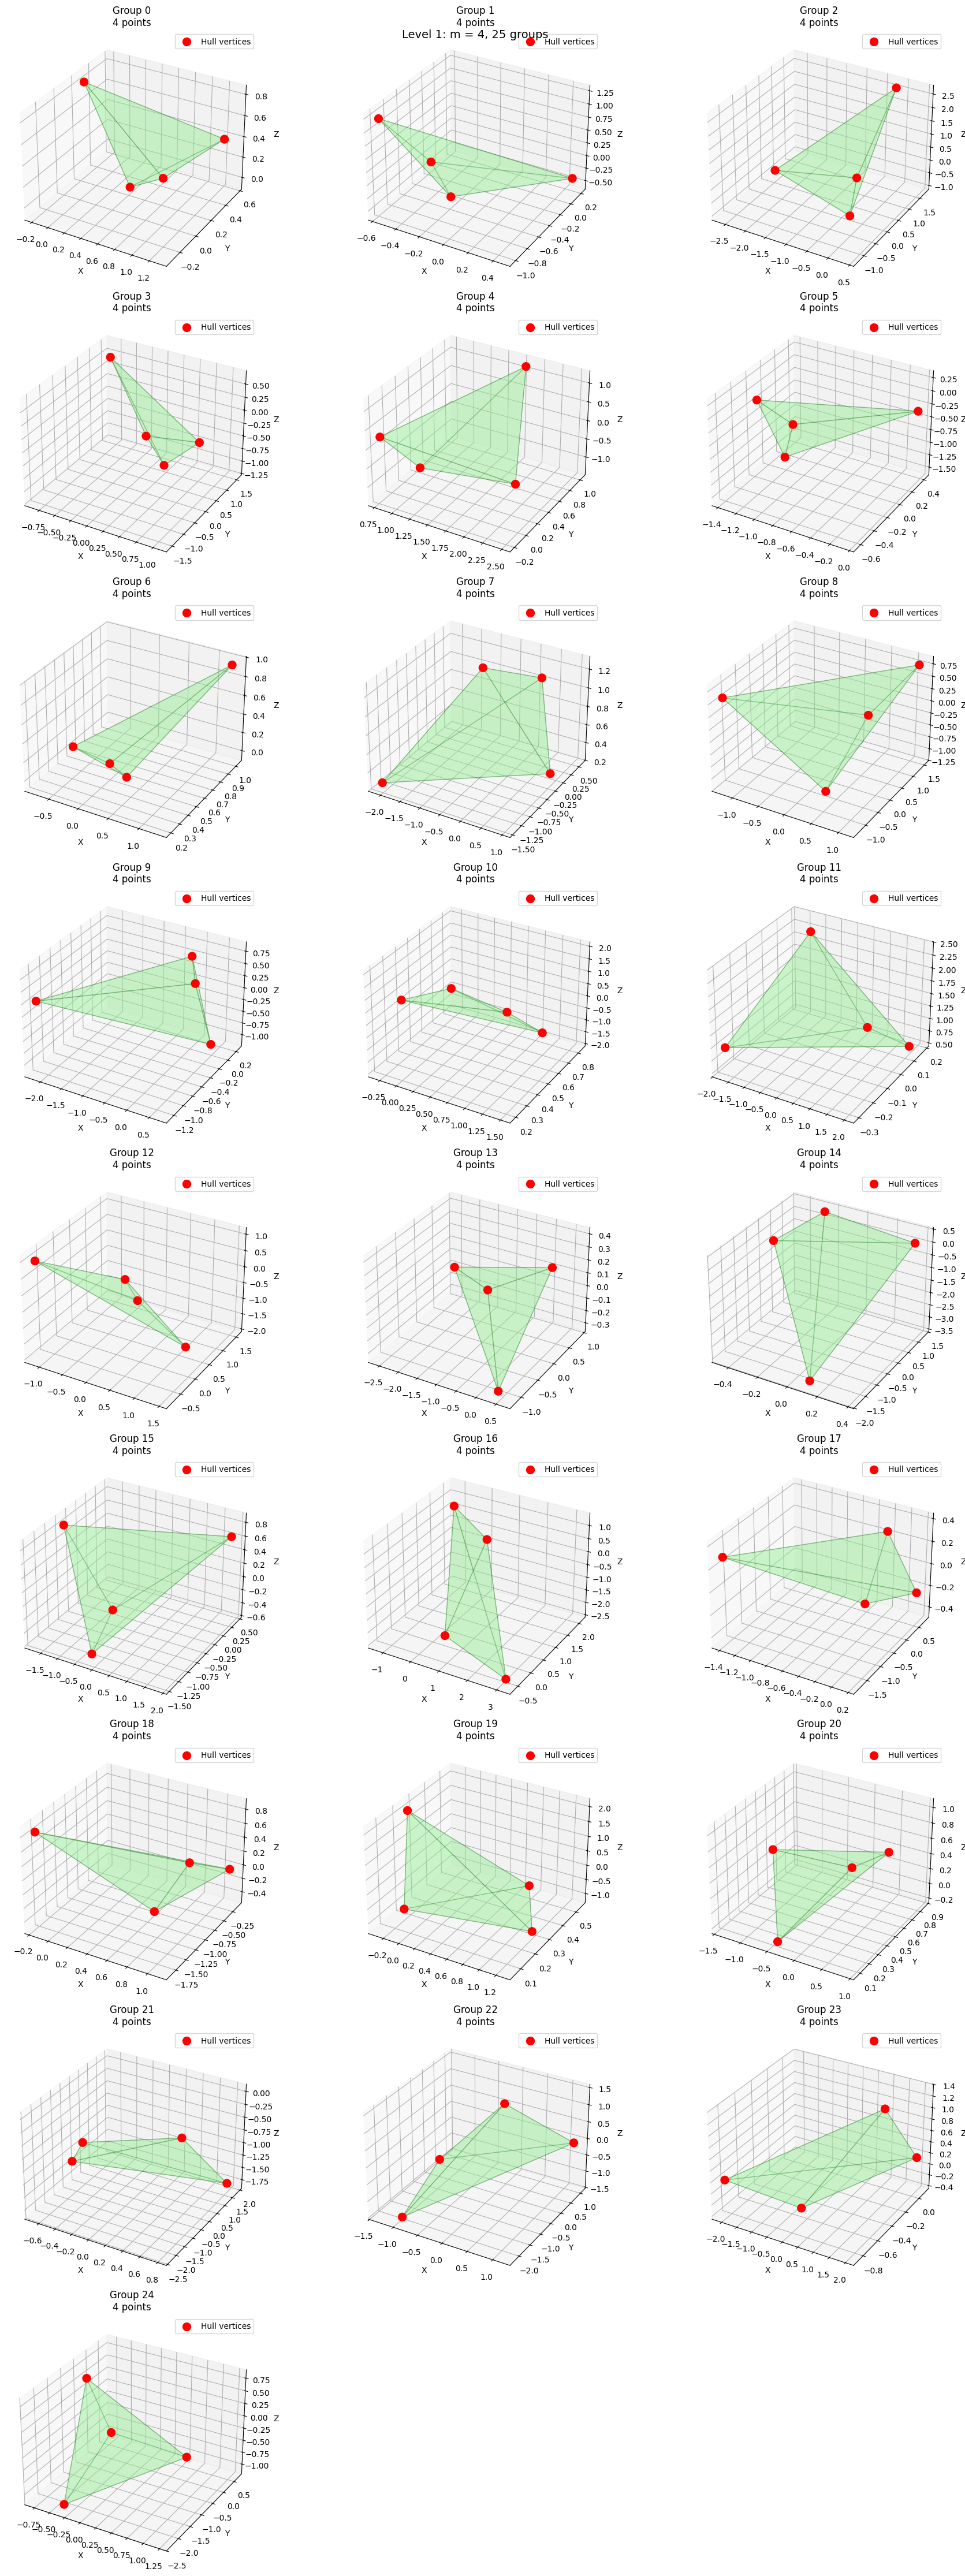

Level 1 visualization complete


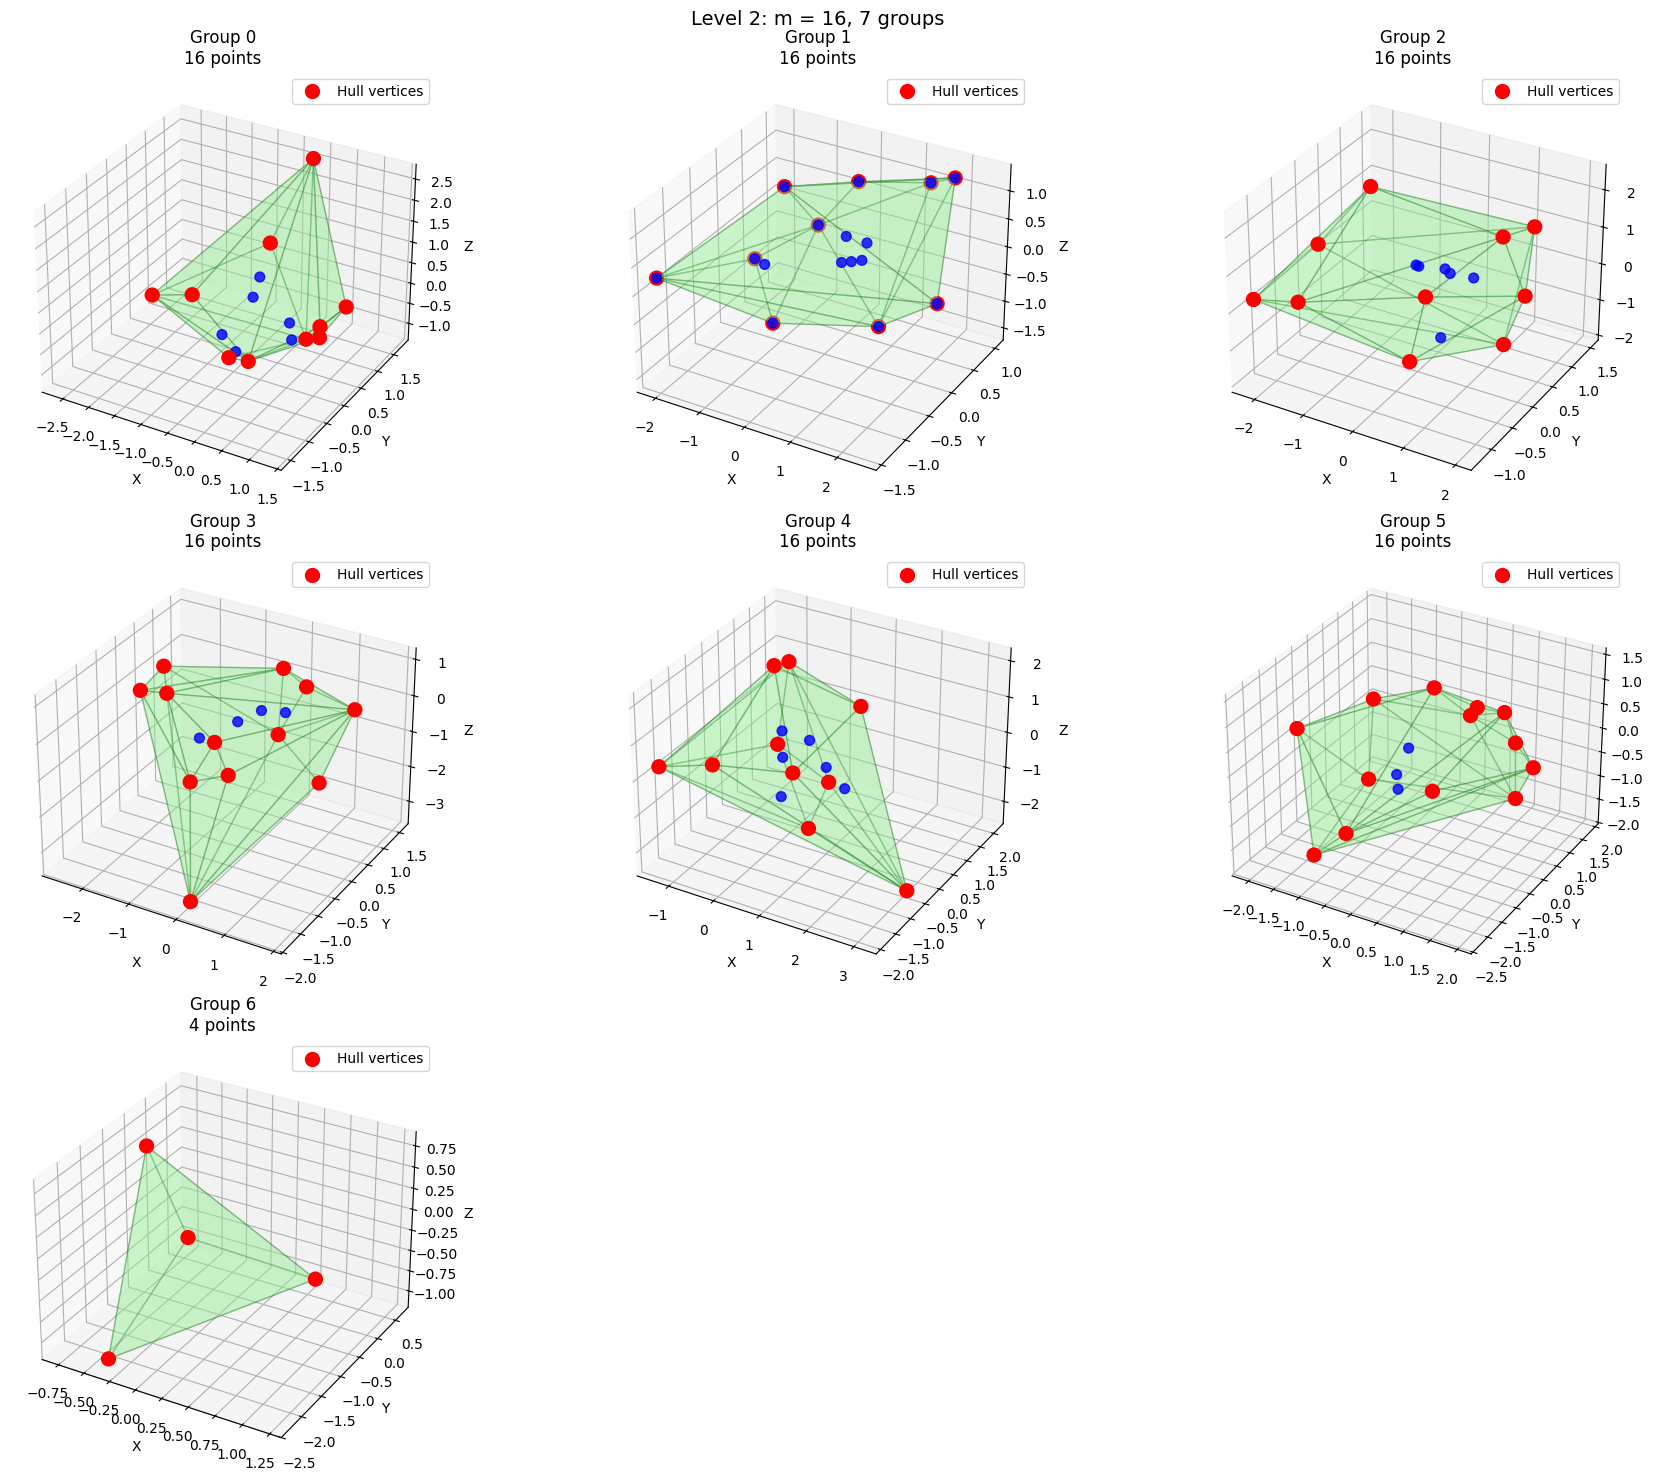

Level 2 visualization complete


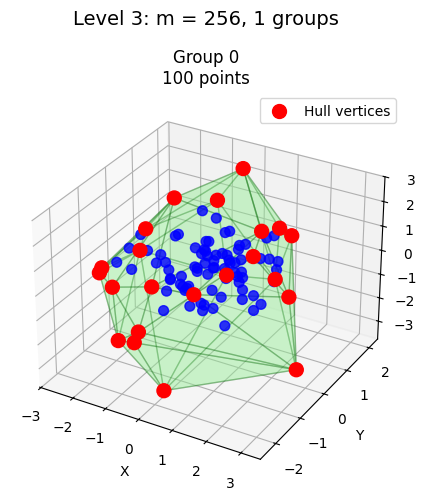

Level 3 visualization complete


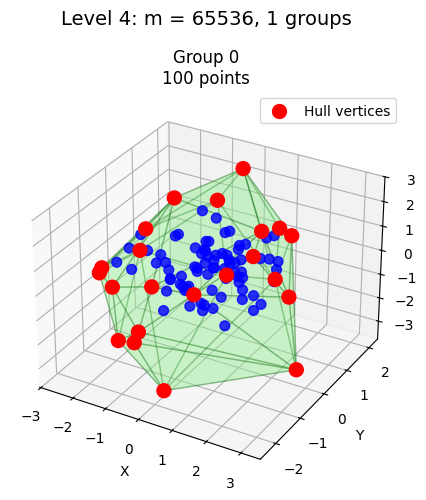

Level 4 visualization complete


In [11]:
# ============================================
# Part 6: Visualization
# ============================================

def visualize_level(level_result, points):
    """Visualize a single level of the algorithm."""
    level = level_result['level']
    groups = level_result['groups']
    groups_hulls = level_result['groups_hulls']

    num_groups = len(groups)
    cols = min(num_groups, 3) if num_groups > 0 else 1
    rows = int(np.ceil(num_groups / cols)) if num_groups > 0 else 1

    fig = plt.figure(figsize=(6 * cols, 5 * rows))

    for j, (group, hull_info) in enumerate(zip(groups, groups_hulls)):
        if hull_info is None:
            continue

        ax = fig.add_subplot(rows, cols, j + 1, projection='3d')

        hull = hull_info['hull']
        group_points = hull_info['points']

        faces = []
        for simplex in hull.simplices:
            face = [group_points[i] for i in simplex]
            faces.append(face)

        poly = Poly3DCollection(faces, alpha=0.25, facecolor='lightgreen',
                                edgecolor='darkgreen', linewidth=1)
        ax.add_collection3d(poly)

        ax.scatter(group_points[:, 0], group_points[:, 1], group_points[:, 2],
                   c='blue', s=50, marker='o', alpha=0.8)

        hull_vertices = group_points[hull.vertices]
        ax.scatter(hull_vertices[:, 0], hull_vertices[:, 1], hull_vertices[:, 2],
                   c='red', s=100, marker='o', alpha=1.0, label='Hull vertices')

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Group {j}\n{len(group)} points')
        ax.legend()

    plt.suptitle(f'Level {level}: m = {level_result["m"]}, {num_groups} groups',
                 fontsize=14)
    plt.tight_layout()
    return fig

# Visualize all levels
print("\nVisualizing all levels...")
for level_result in results:
    fig = visualize_level(level_result, points)
    plt.show()
    print(f"Level {level_result['level']} visualization complete")

## Gift Wrapping Animation

The following animation shows the **incremental gift wrapping** process step by step:
1. **Red thick edge**: The current edge being processed
2. **Yellow stars**: Candidate tangent points from each group
3. **Green star**: The selected best tangent point
4. **Orange face**: The newly formed triangle face
5. **Light blue faces**: Previously built faces

In [12]:
# ============================================
# Gift Wrapping Animation
# ============================================
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def create_gift_wrapping_animation(points, results):
    """Create an animation of the gift wrapping process."""

    # Use the first level result for animation
    level_result = results[0]
    groups = level_result['groups']
    groups_hulls = level_result['groups_hulls']
    dual_hierarchies = level_result['dual_hierarchies']
    num_groups = len(groups)

    # ---- Re-run wrapping with detailed step recording ----
    detailed_steps = []
    merged_faces_so_far = []

    if groups_hulls and groups_hulls[0] is not None:
        initial_hull = groups_hulls[0]['hull']
        initial_points = groups_hulls[0]['points']

        if len(initial_hull.simplices) > 0:
            first_simplex = initial_hull.simplices[0]
            first_face = [initial_points[i] for i in first_simplex]
            merged_faces_so_far.append(first_face)

            edge_queue = []
            seen_edges = set()
            for i in range(3):
                edge = (tuple(first_face[i]), tuple(first_face[(i + 1) % 3]))
                if edge not in seen_edges:
                    edge_queue.append(edge)
                    seen_edges.add(edge)
                    seen_edges.add((edge[1], edge[0]))

            max_iterations = min(15, len(initial_hull.simplices))
            for _ in range(max_iterations):
                if not edge_queue:
                    break
                edge = edge_queue.pop(0)
                edge_pts = (np.array(edge[0]), np.array(edge[1]))

                # Collect ALL candidates with their angles
                candidates = []
                p1, p2 = edge_pts
                edge_midpoint = (p1 + p2) / 2
                plane_normal = compute_plane_normal(p1, p2)

                for g_idx in range(num_groups):
                    hull_info = groups_hulls[g_idx]
                    if hull_info is None:
                        continue
                    hull = hull_info['hull']
                    hull_pts = hull_info['points']
                    for v_idx in hull.vertices:
                        vertex = hull_pts[v_idx]
                        if np.allclose(vertex, p1) or np.allclose(vertex, p2):
                            continue
                        angle = compute_angle(plane_normal, edge_midpoint, vertex)
                        candidates.append({'point': vertex, 'angle': angle, 'group': g_idx})

                if not candidates:
                    continue

                # Sort by angle descending
                candidates.sort(key=lambda c: c['angle'], reverse=True)
                best = candidates[0]

                new_face = [edge_pts[0], edge_pts[1], best['point']]

                detailed_steps.append({
                    'edge': edge_pts,
                    'candidates': candidates[:8],  # top-8 for display
                    'best': best,
                    'new_face': new_face,
                    'faces_before': [f[:] for f in merged_faces_so_far]
                })

                merged_faces_so_far.append(new_face)

                for i in range(3):
                    ne = (tuple(new_face[i]), tuple(new_face[(i + 1) % 3]))
                    if ne not in seen_edges and len(edge_queue) < 30:
                        edge_queue.append(ne)
                        seen_edges.add(ne)
                        seen_edges.add((ne[1], ne[0]))

    if not detailed_steps:
        print("No wrapping steps recorded.")
        return None

    n_steps = len(detailed_steps)
    # 3 sub-frames per step: edge -> candidates -> new face
    total_frames = n_steps * 3

    # Compute axis limits
    pad = 0.5
    x_min, x_max = points[:, 0].min() - pad, points[:, 0].max() + pad
    y_min, y_max = points[:, 1].min() - pad, points[:, 1].max() + pad
    z_min, z_max = points[:, 2].min() - pad, points[:, 2].max() + pad

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Group colors
    group_colors = plt.cm.tab10(np.linspace(0, 1, num_groups))

    def update(frame):
        ax.clear()
        step_idx = frame // 3
        sub_frame = frame % 3
        step = detailed_steps[step_idx]

        # --- Draw all points (dimmed, colored by group) ---
        offset = 0
        for g_idx, group in enumerate(groups):
            ax.scatter(group[:, 0], group[:, 1], group[:, 2],
                       c=[group_colors[g_idx]], s=15, alpha=0.25, marker='o')
            offset += len(group)

        # --- Draw previously built faces ---
        faces_before = step['faces_before']
        if faces_before:
            poly = Poly3DCollection(faces_before, alpha=0.15, facecolor='lightblue',
                                    edgecolor='steelblue', linewidth=0.5)
            ax.add_collection3d(poly)

        # --- Highlight current edge ---
        e1, e2 = step['edge']
        ax.plot([e1[0], e2[0]], [e1[1], e2[1]], [e1[2], e2[2]],
                color='red', linewidth=4, zorder=10)
        ax.scatter(*e1, c='red', s=120, marker='D', zorder=11)
        ax.scatter(*e2, c='red', s=120, marker='D', zorder=11)

        title_text = f"Step {step_idx + 1}/{n_steps}"

        if sub_frame >= 1:
            # --- Show candidate tangent points ---
            for i, cand in enumerate(step['candidates']):
                pt = cand['point']
                g = cand['group']
                alpha = max(0.3, 1.0 - i * 0.1)
                size = max(40, 200 - i * 20)
                ax.scatter(*pt, c='gold', s=size, marker='*', alpha=alpha,
                           edgecolors='orange', linewidths=0.5, zorder=9)
                # Draw dashed line from edge midpoint to candidate
                mid = (e1 + e2) / 2
                ax.plot([mid[0], pt[0]], [mid[1], pt[1]], [mid[2], pt[2]],
                        color='orange', linewidth=0.8, linestyle='--', alpha=alpha * 0.6)

            title_text += "  |  Evaluating candidates"

        if sub_frame >= 2:
            # --- Highlight best point and new face ---
            bp = step['best']['point']
            ax.scatter(*bp, c='lime', s=350, marker='*', edgecolors='darkgreen',
                       linewidths=1.5, zorder=12)

            new_face = step['new_face']
            poly_new = Poly3DCollection([new_face], alpha=0.4, facecolor='orange',
                                        edgecolor='red', linewidth=2)
            ax.add_collection3d(poly_new)

            title_text += f"\n>> Selected from Group {step['best']['group']}"
        elif sub_frame == 0:
            title_text += "  |  Current edge"

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_zlim(z_min, z_max)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(title_text, fontsize=13)
        ax.view_init(elev=25, azim=frame * 2)  # slow rotation

    anim = FuncAnimation(fig, update, frames=total_frames, interval=700, repeat=True)
    plt.close(fig)
    return anim

# Create and display the animation
anim = create_gift_wrapping_animation(points, results)
if anim is not None:
    display(HTML(anim.to_jshtml()))
    print(f"Animation created with {len(results[0]['wrap_steps'])} wrapping steps")
else:
    print("Could not create animation")

Animation created with 4 wrapping steps


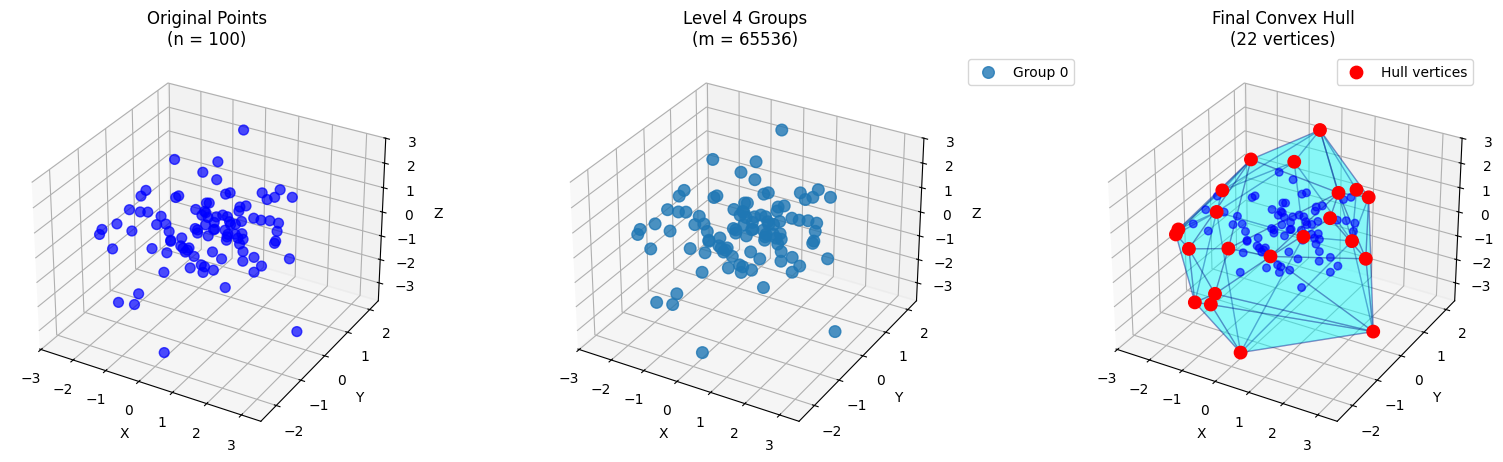


Summary visualization complete


In [13]:
# ============================================
# Part 7: Overall Summary Visualization
# ============================================

def visualize_all_points_and_groups(points, results):
    """Show all points and the final grouping structure"""
    fig = plt.figure(figsize=(15, 5))
    
    # Plot 1: All original points
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(points[:, 0], points[:, 1], points[:, 2], 
                c='blue', s=50, marker='o', alpha=0.7)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title(f'Original Points\n(n = {len(points)})')
    
    # Plot 2: Final level grouping
    if len(results) > 0:
        final_level = results[-1]
        ax2 = fig.add_subplot(132, projection='3d')
        
        colors = plt.cm.tab10(np.linspace(0, 1, len(final_level['groups'])))
        for j, (group, color) in enumerate(zip(final_level['groups'], colors)):
            ax2.scatter(group[:, 0], group[:, 1], group[:, 2],
                       c=[color], s=70, marker='o', alpha=0.8, label=f'Group {j}')
        
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_zlabel('Z')
        ax2.set_title(f'Level {final_level["level"]} Groups\n(m = {final_level["m"]})')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 3: Overall convex hull
    try:
        overall_hull = ConvexHull(points)
        ax3 = fig.add_subplot(133, projection='3d')
        
        faces = []
        for simplex in overall_hull.simplices:
            face = [points[i] for i in simplex]
            faces.append(face)
        
        poly = Poly3DCollection(faces, alpha=0.25, facecolor='cyan',
                                edgecolor='navy', linewidth=1)
        ax3.add_collection3d(poly)
        
        ax3.scatter(points[:, 0], points[:, 1], points[:, 2],
                   c='blue', s=30, marker='o', alpha=0.6)
        
        hull_vertices = points[overall_hull.vertices]
        ax3.scatter(hull_vertices[:, 0], hull_vertices[:, 1], hull_vertices[:, 2],
                   c='red', s=80, marker='o', alpha=1.0, label='Hull vertices')
        
        ax3.set_xlabel('X')
        ax3.set_ylabel('Y')
        ax3.set_zlabel('Z')
        ax3.set_title(f'Final Convex Hull\n({len(overall_hull.vertices)} vertices)')
        ax3.legend()
    except:
        pass
    
    plt.tight_layout()
    return fig

# Create summary visualization
fig = visualize_all_points_and_groups(points, results)
plt.show()
print("\nSummary visualization complete")